2024-12-06 03:26:15,961 - INFO - Successfully synchronized with NTP server: pool.ntp.org
2024-12-06 03:26:15,964 - INFO - Local Sidereal Time: 3.249294932974129
2024-12-06 03:26:15,966 - INFO - Generated time-based key successfully.


Generated Key: 36c9c1cf930b5f603a6c6812accecb1e42b3c92310db8c4be903f5aa08d27ea5


2024-12-06 03:26:16,506 - INFO - Anomaly detection using ML completed. Anomaly Detected: False


Anomaly Detected: False


2024-12-06 03:26:17,026 - INFO - Monte Carlo Simulation completed. Drift Mean: 0.04403148564009371, Drift Std Dev: 1.0096043820166893, Median: 0.07741882100723327, MAD: 0.7118035732313823


Drift Mean: 0.04403148564009371, Drift Standard Deviation: 1.0096043820166893, Median Drift: 0.07741882100723327, MAD: 0.7118035732313823


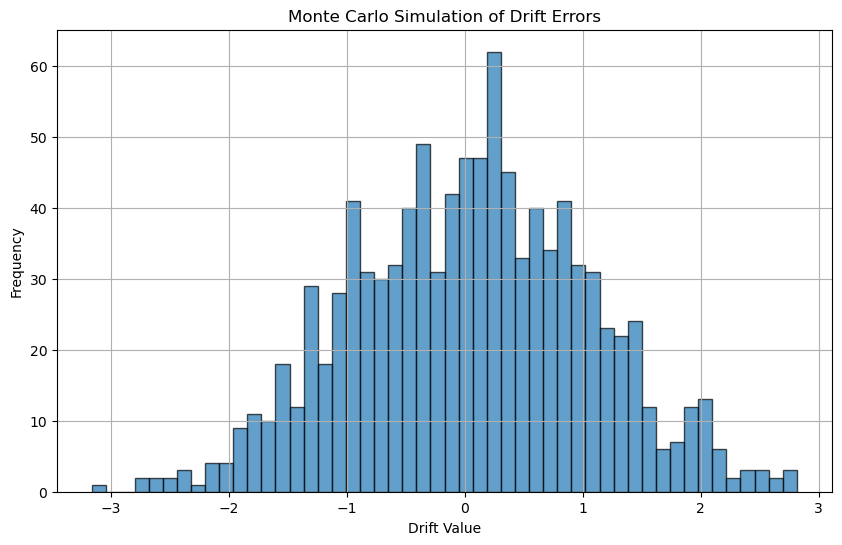

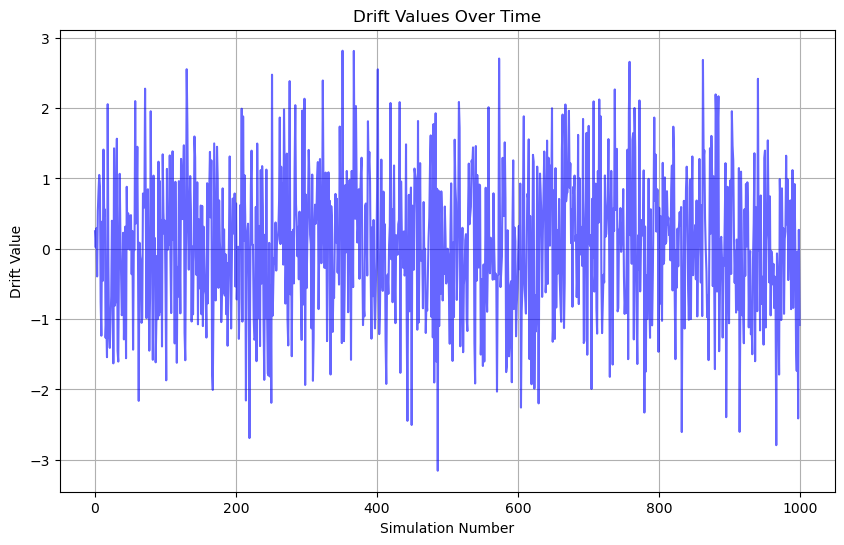

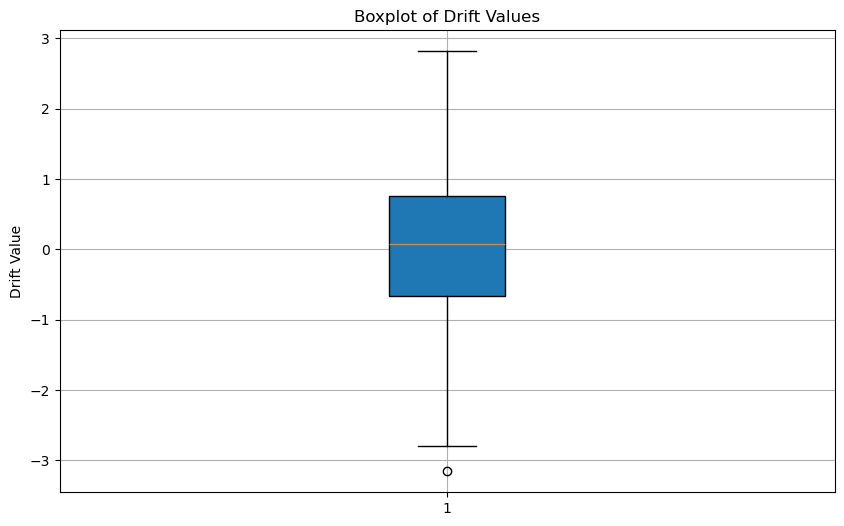

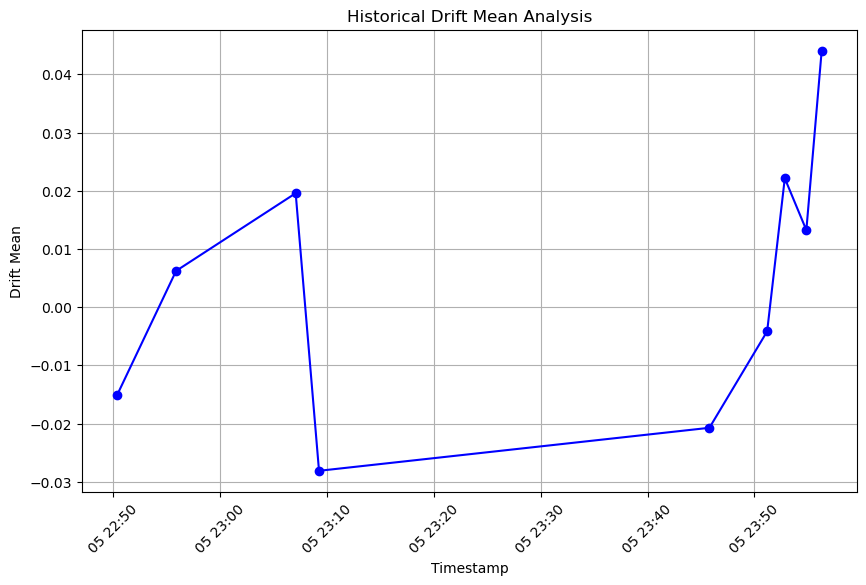

2024-12-06 03:26:18,699 - INFO - Anomaly detection using ML completed. Anomaly Detected: False
.2024-12-06 03:26:18,702 - INFO - Generated time-based key successfully.
.2024-12-06 03:26:18,705 - INFO - Power reserve managed. Current reserve: 14
.
----------------------------------------------------------------------
Ran 3 tests in 0.498s

OK


In [20]:
import time
import datetime
import numpy as np
from gps3 import gps3
import pytz
import hashlib
import ntplib
import random
import matplotlib.pyplot as plt
import logging
import sqlite3
import joblib
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from concurrent.futures import ThreadPoolExecutor
import functools
from cachetools import cached, TTLCache
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import pika
import pandas as pd
from sklearn.model_selection import GridSearchCV
import threading
import unittest


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


C = 299792458  
G = 6.67430e-11  
M_EARTH = 5.972e24  
R_EARTH = 6371e3  


cache = TTLCache(maxsize=100, ttl=300)  


anomaly_detector_isolation = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
anomaly_detector_rf = RandomForestClassifier(n_estimators=100, random_state=42)


RABBITMQ_HOST = 'localhost'
QUEUE_NAME = 'distributed_tasks'



def create_features(time_shifts, frequency_stability):
    rolling_mean = np.mean(time_shifts)
    rolling_std = np.std(time_shifts)
    features = time_shifts + frequency_stability + [rolling_mean, rolling_std]
    return np.array(features).reshape(1, -1)


def tune_model(model, X, y):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'random_state': [42]
    }
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X, y)
    logging.info(f"Best parameters found: {grid_search.best_params_}")
    return grid_search.best_estimator_


def connect_gps():
    gps_socket = gps3.GPSDSocket()
    data_stream = gps3.DataStream()
    gps_socket.connect()
    gps_socket.watch()
    
    for new_data in gps_socket:
        if new_data:
            data_stream.unpack(new_data)
            logging.info(f"GPS Data - Time: {data_stream.TPV['time']}, Latitude: {data_stream.TPV['lat']}, Longitude: {data_stream.TPV['lon']}")
            break


@cached(cache)
def sync_with_earth_clock():
    client = ntplib.NTPClient()
    ntp_servers = ['pool.ntp.org', 'time.nist.gov', 'time.google.com']
    retries = 3
    for server in ntp_servers:
        for attempt in range(retries):
            try:
                response = client.request(server)
                logging.info(f"Successfully synchronized with NTP server: {server}")
                return response.tx_time
            except Exception as e:
                logging.error(f"Failed to synchronize with NTP server {server} on attempt {attempt + 1}: {e}")
                time.sleep(5)  # Retry after 5 seconds
    logging.error("All attempts to synchronize with NTP servers failed.")
    return time.time()  # Fallback to local time


def calculate_lst(longitude, utc_time):
    """
    Calculate the Local Sidereal Time (LST).
    """
    jd = utc_time.timestamp() / 86400.0 + 2440587.5  # Julian day number
    gst = (jd - 2451545.0) / 36525  # Greenwich Sidereal Time
    lst = gst + longitude / 15.0
    return lst % 24


@cached(cache)
def generate_time_based_key(frequency, temperature_drift):
    base_key = hashlib.sha256((str(frequency) + str(temperature_drift)).encode()).digest()
    key = hashlib.sha256(base_key).digest()
    logging.info("Generated time-based key successfully.")
    return key


def update_password(rotation_policy):
    password = hashlib.sha256(rotation_policy.encode()).hexdigest()
    logging.info("Password updated successfully.")
    return password


def detect_anomaly_ml(time_shifts, frequency_stability):
    features = create_features(list(time_shifts), list(frequency_stability))
    with ThreadPoolExecutor() as executor:
        future_isolation = executor.submit(anomaly_detector_isolation.fit_predict, features)
        future_rf = executor.submit(anomaly_detector_rf.fit, features, [0])
        prediction_isolation = future_isolation.result()
        rf_model = future_rf.result()
        prediction_rf = rf_model.predict(features) if rf_model else []
    anomaly_detected = bool(prediction_isolation[0] == -1 or (prediction_rf and prediction_rf[0] == 1))
    logging.info(f"Anomaly detection using ML completed. Anomaly Detected: {anomaly_detected}")
    return anomaly_detected


def send_alert_email(subject, body):
    sender_email = "your_email@gmail.com"
    receiver_email = "recipient_email@gmail.com"
    password = "your_password"
    
    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject
    
    msg.attach(MIMEText(body, 'plain'))
    
    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, msg.as_string())
        server.quit()
        logging.info("Alert email sent successfully.")
    except Exception as e:
        logging.error(f"Failed to send alert email: {e}")


def manage_energy_reserves(power_reserve):
    """
    Track power reserve and optimize discharge.
    """
    if power_reserve < 10:  
        logging.warning("Warning: Low power reserve.")
        send_alert_email("Low Power Reserve Alert", "Power reserve is critically low!")
    power_reserve = max(power_reserve - 1, 0)
    logging.info(f"Power reserve managed. Current reserve: {power_reserve}")
    return power_reserve



def publish_task_to_queue(task_data):
    connection = pika.BlockingConnection(pika.ConnectionParameters(host=RABBITMQ_HOST))
    channel = connection.channel()
    channel.queue_declare(queue=QUEUE_NAME)
    channel.basic_publish(exchange='', routing_key=QUEUE_NAME, body=str(task_data))
    logging.info(f"Task published to queue: {task_data}")
    connection.close()


def monte_carlo_simulation_for_drift():
    num_simulations = 1000
    with ThreadPoolExecutor() as executor:
        drift_values = list(executor.map(lambda _: random.gauss(0, 1), range(num_simulations)))
    drift_values = [float(value) for value in drift_values]  
    median_drift = np.median(drift_values)
    mad_drift = np.median(np.abs(drift_values - median_drift))  
    logging.info(f"Monte Carlo Simulation completed. Drift Mean: {np.mean(drift_values)}, Drift Std Dev: {np.std(drift_values)}, Median: {median_drift}, MAD: {mad_drift}")
    return drift_values, np.mean(drift_values), np.std(drift_values), median_drift, mad_drift


def visualize_drift(drift_values):
    drift_values = [float(value) for value in drift_values]  
    plt.figure(figsize=(10, 6))
    plt.hist(drift_values, bins=50, alpha=0.7, edgecolor='black')
    plt.title('Monte Carlo Simulation of Drift Errors')
    plt.xlabel('Drift Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    
    plt.figure(figsize=(10, 6))
    plt.plot(drift_values, color='blue', alpha=0.6)
    plt.title('Drift Values Over Time')
    plt.xlabel('Simulation Number')
    plt.ylabel('Drift Value')
    plt.grid(True)
    plt.show()

    
    plt.figure(figsize=(10, 6))
    plt.boxplot(drift_values, patch_artist=True)
    plt.title('Boxplot of Drift Values')
    plt.ylabel('Drift Value')
    plt.grid(True)
    plt.show()


def save_to_db(drift_mean, drift_std, drift_median, drift_mad):
    conn = sqlite3.connect('drift_analysis.db')
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS DriftData (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            drift_mean REAL,
            drift_std REAL,
            drift_median REAL,
            drift_mad REAL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    ''')
    cursor.execute('''
        INSERT INTO DriftData (drift_mean, drift_std, drift_median, drift_mad)
        VALUES (?, ?, ?, ?)
    ''', (drift_mean, drift_std, drift_median, drift_mad))
    conn.commit()
    conn.close()


def generate_historical_report():
    conn = sqlite3.connect('drift_analysis.db')
    df = pd.read_sql_query("SELECT * FROM DriftData", conn)
    conn.close()
    if df.empty:
        logging.info("No historical data available for analysis.")
        return

    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['timestamp'], df['drift_mean'].astype(float), marker='o', linestyle='-', color='b')  # Convert drift_mean to float
    plt.title('Historical Drift Mean Analysis')
    plt.xlabel('Timestamp')
    plt.ylabel('Drift Mean')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


class TestCriticalFunctions(unittest.TestCase):
    def test_generate_time_based_key(self):
        key1 = generate_time_based_key(1000, 5)
        key2 = generate_time_based_key(1000, 5)
        self.assertEqual(key1, key2, "Keys should be deterministic and identical for the same inputs")

    def test_anomaly_detection(self):
        anomaly = detect_anomaly_ml([5, 3, 1], [0.8, 0.6, 0.4])
        self.assertIsInstance(anomaly, bool, "Anomaly detection should return a boolean value")

    def test_manage_energy_reserves(self):
        reserve = manage_energy_reserves(15)
        self.assertEqual(reserve, 14, "Energy reserve should decrease by 1")


if __name__ == "__main__":
    
    
    earth_time = sync_with_earth_clock()
    lst = calculate_lst(longitude=45.0, utc_time=datetime.datetime.fromtimestamp(earth_time, tz=datetime.timezone.utc))
    logging.info(f"Local Sidereal Time: {lst}")
    
    
    key = generate_time_based_key(frequency=1000, temperature_drift=5)
    print(f"Generated Key: {key.hex()}")
    
   
    anomaly = detect_anomaly_ml(time_shifts=[5, 3, 1], frequency_stability=[0.8, 0.6, 0.4])
    print(f"Anomaly Detected: {anomaly}")
    if anomaly:
        send_alert_email("Anomaly Detected Alert", "An anomaly was detected in the time synchronization system.")
    
    
    drift_values, drift_mean, drift_std, drift_median, drift_mad = monte_carlo_simulation_for_drift()
    print(f"Drift Mean: {drift_mean}, Drift Standard Deviation: {drift_std}, Median Drift: {drift_median}, MAD: {drift_mad}")
    
    
    save_to_db(drift_mean, drift_std, drift_median, drift_mad)
    
    
    visualize_drift(drift_values)
    
    
    generate_historical_report()
    
    
    unittest.main(argv=[''], exit=False)
